In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import torch
from torch import nn, functional as F

In [2]:
path = Path('../../data/large')

In [3]:
ab = pd.read_csv(path/'dC_01.csv', header=None).values[0]
bestKnow = pd.read_csv(path/'Best_Know1Fxs.csv', header=None).values[0]
bestKnow = bestKnow[:100].astype(float)
java_results = pd.read_csv(path/'Feasibility1Fs.csv', header=None).values[0]
java_results = java_results[:-1].astype(float)
java_results_all = pd.read_csv(path/'Feasibility1Fs.csv', header=None).iloc[:,:-1]

In [4]:
D = 30
nn_window = 5
nn_nf = 4
frequency = 1_000
max_times = len(ab)
total_generations = max_times * frequency + 1000

In [5]:
class SimpleModel(nn.Module):
    def __init__(self, d=D, w=nn_window, nf=nn_nf):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(self.act(fts))

model = SimpleModel()

In [8]:
def fitness_func(indiv, b, t): return (indiv.data**2).sum()
def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

population = Population.new_random(dimension=D)
nn_trainer = partial(NNTrainer, model=model, window=nn_window)
opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                   max_times=max_times, frequency=frequency, callbacks=[nn_trainer])
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'best': None}

A proper report should be shown here :)
Total time: 00:28


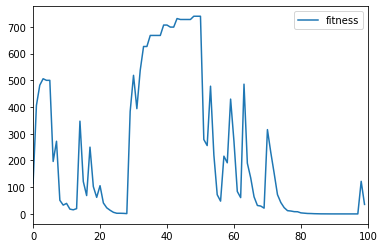

In [9]:
opt.run(total_generations)

In [13]:
pred = opt.nn_trainer.get_next_best()
pred

tensor([-1.9056, -1.5151, -1.7418, -1.1667, -0.8896, -1.7008, -1.1283, -1.2325,
        -2.4601,  0.3844, -2.3489, -0.6079, -1.3290, -2.2324, -0.7060, -1.0983,
        -1.1261, -1.3093, -1.5437,  0.1791, -1.4818, -2.3261, -1.0222, -0.5830,
        -1.4738, -1.6044, -1.6331, -0.9234, -0.0934, -2.6567])

In [19]:
fitness_func(opt.best, 0, 0), fitness_func(pred, 0, 0)

(35.520573, tensor(67.0613))

In [29]:
constraint_func(opt.best, ab, opt.time-1), constraint_func(pred, ab, opt.time-1)

(-15.70446643727459, tensor(-24.4149))

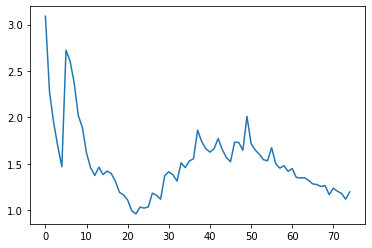

In [30]:
plt.plot(opt.nn_trainer.train_losses)

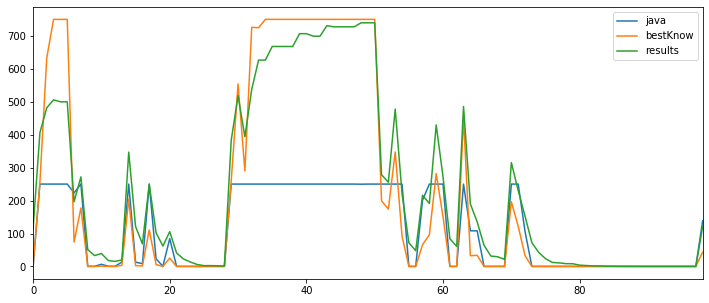

In [31]:
df = pd.DataFrame({'java':java_results, 'bestKnow':bestKnow[:-1], 'results': opt.recorder.best_times_fitness[:-1]})
df.plot(figsize=(12,5));